In [4]:
import os
from typing import TypedDict, Annotated, Sequence, List
from langgraph.graph import Graph, END 
from langchain_core.messages import HumanMessage, AIMessage
from openai import OpenAI
from PIL import Image
import io
from IPython.display import display, Image as IPImage

from langchain_core.runnables.graph import MermaidDrawMethod

import asyncio
import aiohttp
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
import os
from dotenv import load_dotenv
load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY is not set in the .env file.")
print("Gemini api key loaded successfully")

if not LANGSMITH_API_KEY:
    raise ValueError("LANGSMITH_API_KEY is not set in the .env file.")
print("LANGSMITH_API_KEY loaded successfully")
# Set OpenAI API key
from typing import Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
class GraphState(TypedDict):
    messages: Annotated[Sequence[HumanMessage | AIMessage], "The messages in the conversation"]
    query: Annotated[str, "Input query describing the character and scene"]
    plot: Annotated[str, "Generated plot for the GIF"]
    character_description: Annotated[str, "Detailed description of the main character or object"]
    image_prompts: Annotated[List[str], "List of prompts for each frame"]
    image_urls: Annotated[List[str], "List of URLs for generated images"]
    gif_data: Annotated[bytes, "GIF data in bytes"]
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key=GEMINI_API_KEY  )

Gemini api key loaded successfully
LANGSMITH_API_KEY loaded successfully


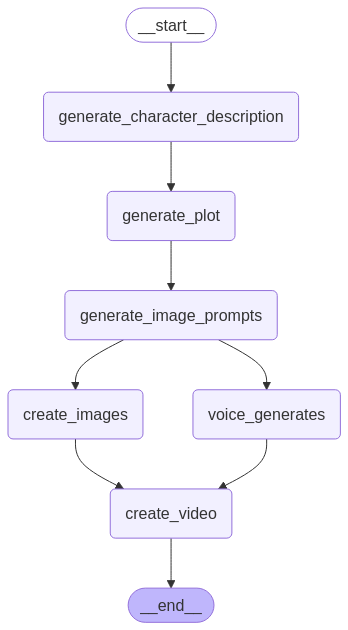

In [87]:
import os 
from datetime import datetime 
import logging
from gtts import gTTS  
import requests 
from IPython.display import display, Image 
from dotenv import load_dotenv
load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY is not set in the .env file.")
print("Gemini api key loaded successfully")

if not LANGSMITH_API_KEY:
    raise ValueError("LANGSMITH_API_KEY is not set in the .env file.")
print("LANGSMITH_API_KEY loaded successfully")

class GraphState(TypedDict):
    # messages: Annotated[Sequence[HumanMessage | AIMessage], "The messages in the conversation"]
    query: Annotated[str, "Input query describing the character and scene"]
    story: Annotated[str, "Generated story"]
    plot: Annotated[str, "Generated plot for the GIF"]
    character_description: Annotated[str, "Detailed description of the main character or object"]
    image_prompts: Annotated[List[str], "List of prompts for each frame"]
  
    
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key=GEMINI_API_KEY  )

def generate_story(state: GraphState) -> GraphState: 
    story_generated_prompt = '''Imagine you are a skilled storyteller tasked with creating a compelling narrative based on the following plot outline. Your goal is to generate a detailed and realistic story that captivates the reader.Based on the query {query}'''
    query = state["query"]
    response = llm.invoke([HumanMessage(content=story_generated_prompt.format(query=query))])
    state["story"] = response.content
    return state

def generate_character_description(state: GraphState) -> GraphState: 
    generate_description_prompt = '''Based on the Story {story}, create a detailed description of the main character, object, or scene. Include specific details about appearance, characteristics, and any unique features. This description will be used to maintain consistency across multiple images.'''
    gen_story = state["query"]
    response = llm.invoke([HumanMessage(content=generate_description_prompt.format(story=gen_story))])
    state["character_description"] = response.content
    return state

def generate_plot(state: GraphState) -> GraphState: 
    generate_plot_prompt = '''Create a short, 5-step plot for a video based on this story: '{story}' and featuring this description: {character_description}. Each step should be a brief description of a single frame, maintaining consistency throughout. Keep it family-friendly and avoid any sensitive themes.'''
    gen_story = state["query"]
    character_description = state["character_description"] 
    response = llm.invoke([HumanMessage(content=generate_plot_prompt.format(story=gen_story, character_description=character_description))])
    state["plot"] = response.content    
    return state

def generate_image_prompts(state: GraphState) -> GraphState:
    
    generate_image_prompts = """Based on this plot: {plot} and featuring this description: {character_description}, generate 5 specific, family-friendly image prompts, one for each step. Each prompt should be detailed enough for image generation, maintaining consistency, and suitable for DALL-E. 

                            Always include the following in EVERY prompt to maintain consistency:
                            1. A brief reminder of the main character or object's key features
                            2. The specific action or scene described in the plot step
                            3. Any relevant background or environmental details

                            Format each prompt as a numbered list item, like this:
                            1. [Your prompt here]
                            2. [Your prompt here]
                            ... and so on.""" 

    plot = state["plot"]
    character_description = state["character_description"]
    response = llm.invoke([HumanMessage(content=generate_image_prompts.format(plot=plot, character_description=character_description))])
  
    prompts = []
    for line in response.content.split("\n"):
        if line.strip().startswith(("1.", "2.", "3.", "4.", "5.")):
            prompt = line.split(".", 1)[1].strip()
            prompts.append(
                f"Create a detailed, photorealistic image of the following scene: {prompt}"
            )

    if len(prompts) != 5:
        raise ValueError( f"Expected 5 prompts, but got {len(prompts)}. Please try again.")

    state["image_prompts"] = prompts
    return state









def saveImage(image_content, save_path):
    output_folder = os.path.dirname(save_path)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    with open(save_path, "wb") as f:
        f.write(image_content) 

def images_generates(prompt: str):
    try:
        # response = client.images.generate(
        #     model=imagemodel,
        #     prompt=prompt,
        #     quality="standard",
        #     n=1,
        # )
        # image_url = response.data[0].url 
        image_url =  "https://www.w3schools.com/w3images/lights.jpg" 
        return image_url
    
    except Exception as e: 
        logging.error(f"Unexpected error generating image: {e}")
        raise

 


def finalscenesfun(scenes):
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    dynamic_folder = f"images_{timestamp}"
    output_folder = os.path.join("Generated_images", dynamic_folder)
    
    for i, scene in enumerate(scenes):
        try: 
         
            finalScenes=" ".join(scene['summary'].split()[1:])
            prompt = f"Please generate a realistic image based on the following scene description: {finalScenes}"
            imageUrl = images_generates(prompt) 
            if not imageUrl:
                raise ValueError("Generated image URL is empty.")
            
            imageContent = requests.get(imageUrl).content
            if not imageContent:
                raise ValueError("Failed to retrieve image content.")

            save_path = os.path.join(output_folder, f"image_scene_{i+1}.png")
            saveImage(imageContent, save_path)
            print(f"Images saved to {save_path}")            
            
        except Exception as e: 
            logging.error(f"Error processing scene {i+1}: {e}")
            continue    

    return output_folder 





def voice_generates(text: str, file_name: str, folder: str):
    try: 
        tts = gTTS(text)
        if not os.path.exists(folder):
            os.makedirs(folder)
        save_path = os.path.join(folder, file_name)
        tts.save(save_path) 
        return save_path
   
    except Exception as e: 
        logging.error(f"Unexpected error: {e}")
        return None




def finalvoicefun(sceneList):
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    dynamic_folder_voice = f"voice_{timestamp}"
    output_folder_voice = os.path.join("Generated_voice", dynamic_folder_voice)
    voice_paths = []
    for i, scene in enumerate(sceneList):
        try:
            voice_path = voice_generates(
                
                scene["summary"], f"voice_scene_{i+1}.mp3", output_folder_voice
            )
            
            if voice_path:
                voice_paths.append(voice_path)
                print(f"Voiceover saved locally: {voice_path}")
            else:
                print(f"Failed to save voiceover for scene {i+1}.")
        except Exception as e:
            print(f"Error generating voice for scene {i+1}: {e}")
    return output_folder_voice


def final_video_output():
    pass
from langgraph.graph import StateGraph
workflow =   StateGraph(GraphState)
 
workflow.add_node("generate_story", generate_story)
workflow.add_node("generate_character_description", generate_character_description)
workflow.add_node("generate_plot", generate_plot)
workflow.add_node("generate_image_prompts", generate_image_prompts)
workflow.add_node("create_images", finalscenesfun)
workflow.add_node("voice_generates", finalvoicefun)
workflow.add_node("create_video", final_video_output)
# workflow.add_node("create_gif", create_gif)

workflow.add_edge(START, "generate_story")
workflow.add_edge('generate_story', "generate_character_description")
workflow.add_edge("generate_character_description", "generate_plot")
workflow.add_edge("generate_plot", "generate_image_prompts")
workflow.add_edge("generate_image_prompts", "create_images")
workflow.add_edge("generate_image_prompts", "voice_generates")
workflow.add_edge("create_images", "create_video")
workflow.add_edge("voice_generates", "create_video")
workflow.add_edge("create_video", END)



app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))
 

In [43]:
async def get_image_data(session, url: str):
    """Fetch image data from a given URL."""
    async with session.get(url) as response:
        if response.status == 200:
            return await response.read()
    return None


def generate_character_description(state: GraphState) -> GraphState:
    """Generate a detailed description of the main character or scene."""
    query = state["query"]
    response = llm.invoke(
        [
            HumanMessage(
                content=f"Based on the query '{query}', create a detailed description of the main character, object, or scene. Include specific details about appearance, characteristics, and any unique features. This description will be used to maintain consistency across multiple images."
            )
        ]
    )
    state["character_description"] = response.content
    return state


def generate_plot(state: GraphState) -> GraphState:
    """Generate a 5-step plot for the GIF animation."""
    query = state["query"]
    character_description = state["character_description"]
    response = llm.invoke(
        [
            HumanMessage(
                content=f"Create a short, 5-step plot for a GIF based on this query: '{query}' and featuring this description: {character_description}. Each step should be a brief description of a single frame, maintaining consistency throughout. Keep it family-friendly and avoid any sensitive themes."
            )
        ]
    )
    state["plot"] = response.content
    return state


def generate_image_prompts(state: GraphState) -> GraphState:
    """Generate specific image prompts for each frame of the GIF."""
    plot = state["plot"]
    character_description = state["character_description"]
    response = llm.invoke(
        [
            HumanMessage(
                content=f"""Based on this plot: '{plot}' and featuring this description: {character_description}, generate 5 specific, family-friendly image prompts, one for each step. Each prompt should be detailed enough for image generation, maintaining consistency, and suitable for DALL-E. 

Always include the following in EVERY prompt to maintain consistency:
1. A brief reminder of the main character or object's key features
2. The specific action or scene described in the plot step
3. Any relevant background or environmental details

Format each prompt as a numbered list item, like this:
1. [Your prompt here]
2. [Your prompt here]
... and so on."""
            )
        ]
    )

    prompts = []
    for line in response.content.split("\n"):
        if line.strip().startswith(("1.", "2.", "3.", "4.", "5.")):
            prompt = line.split(".", 1)[1].strip()
            prompts.append(
                f"Create a detailed, photorealistic image of the following scene: {prompt}"
            )

    if len(prompts) != 5:
        raise ValueError(
            f"Expected 5 prompts, but got {len(prompts)}. Please try again."
        )

    state["image_prompts"] = prompts
    return state


# async def create_image(prompt: str, retries: int = 3):
#     """Generate an image using DALL-E based on the given prompt."""
#     for attempt in range(retries):
#         try:
#             response = await asyncio.to_thread(
#                 client.images.generate,
#                 model="dall-e-3",
#                 prompt=prompt,
#                 size="1024x1024",
#                 quality="standard",
#                 n=1,
#             )
#             return response.data[0].url
#         except Exception as e:
#             if attempt == retries - 1:
#                 print(f"Failed to generate image for prompt: {prompt}")
#                 print(f"Error: {str(e)}")
#                 return None
#             await asyncio.sleep(2)  # Wait before retrying


# async def create_images(state: GraphState) -> GraphState:
#     """Generate images for all prompts in parallel."""
#     image_prompts = state["image_prompts"]
#     tasks = [create_image(prompt) for prompt in image_prompts]
#     image_urls = await asyncio.gather(*tasks)
#     state["image_urls"] = image_urls
#     return state
async def create_images(state: GraphState) -> GraphState:
    """Return static image URLs instead of generating images for now."""

    # Placeholder URLs (replace these with real image URLs in the future)
    static_image_ursls = [ 
        "https://chatgpt.com/c/67da2d85-b2b0-8005-ab17-dfb058b583ac0",
        "https://chatgpt.com/c/67da2d85-b2b0-8005-ab17-dfb058b583ac",
    ]
    static_image_urls = [
        "https://fastly.picsum.photos/id/672/400/300.jpg?hmac=aW9DdMOISdmGtITiTV4aG3vW7OUHjyVmvecB8rjWhdA",
        "https://fastly.picsum.photos/id/790/400/301.jpg?hmac=VELjWS1r3PwluwR9Q2zuR_-YR8eNqTFEAW3oWcjQsBo",
        "https://fastly.picsum.photos/id/672/400/300.jpg?hmac=aW9DdMOISdmGtITiTV4aG3vW7OUHjyVmvecB8rjWhdA",
        "https://fastly.picsum.photos/id/672/400/300.jpg?hmac=aW9DdMOISdmGtITiTV4aG3vW7OUHjyVmvecB8rjWhdA",
        "https://fastly.picsum.photos/id/790/400/301.jpg?hmac=VELjWS1r3PwluwR9Q2zuR_-YR8eNqTFEAW3oWcj"]
    # Assign static URLs to state
    state["image_urls"] = static_image_urls
    return state


async def create_gif(state: GraphState) -> GraphState:
    """Create a GIF from the generated images."""
    image_urls = state["image_urls"]
    images = []
    async with aiohttp.ClientSession() as session:
        tasks = [get_image_data(session, url) for url in image_urls if url]
        image_data_list = await asyncio.gather(*tasks)

    for img_data in image_data_list:
        if img_data:
            images.append(Image.open(io.BytesIO(img_data)))

    if images:
        gif_buffer = io.BytesIO()
        images[0].save(
            gif_buffer,
            format="GIF",
            save_all=True,
            append_images=images[1:],
            duration=1000,
            loop=0,
        )
        state["gif_data"] = gif_buffer.getvalue()
    else:
        state["gif_data"] = None
    return state

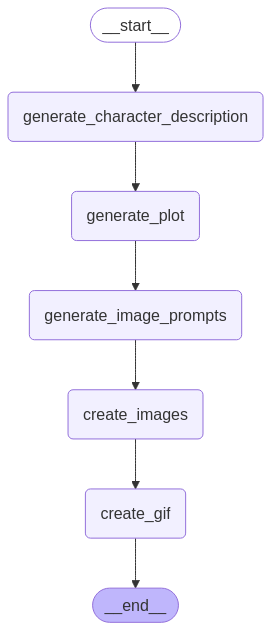


Generated Plot:
Here's a 5-step GIF plot for Bartholomew Buttons, the feline scribe:

**Step 1:** Bartholomew Buttons, in his top hat and monocle (slightly askew!), sits poised at his mahogany desk.  His green eyes sparkle with concentration as he dips his quill pen into the inkwell.  The carved cat silhouette on the desk is visible.

**Step 2:** Bartholomew carefully begins writing in his leather-bound journal, his right paw moving with surprising precision.  His whiskers twitch slightly.

**Step 3:** A close-up shot focusing on Bartholomew's meticulous handwriting in the journal. The words are surprisingly legible.

**Step 4:** Bartholomew pauses, seemingly considering his next sentence, his monocle wobbling slightly. A hint of a mischievous glint appears in his eyes.

**Step 5:** Bartholomew resumes writing, a satisfied expression on his face. He straightens his top hat with a delicate paw. The scene ends with a gentle close-up on his perfectly groomed paw holding the quill.


Imag

In [44]:
workflow = Graph()

workflow.add_node("generate_character_description", generate_character_description)
workflow.add_node("generate_plot", generate_plot)
workflow.add_node("generate_image_prompts", generate_image_prompts)
workflow.add_node("create_images", create_images)
workflow.add_node("create_gif", create_gif)

workflow.add_edge("generate_character_description", "generate_plot")
workflow.add_edge("generate_plot", "generate_image_prompts")
workflow.add_edge("generate_image_prompts", "create_images")
workflow.add_edge("create_images", "create_gif")
workflow.add_edge("create_gif", END)

workflow.set_entry_point("generate_character_description")

app = workflow.compile()
display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


async def run_workflow(query: str):
    """Run the LangGraph workflow and display results."""
    initial_state = {
        "messages": [],
        "query": query,
        "plot": "",
        "character_description": "",
        "image_prompts": [],
        "image_urls": [],
        "gif_data": None,
    }

    try:
        result = await app.ainvoke(initial_state)

        print("\nGenerated Plot:")
        print(result["plot"])

        print("\nImage Prompts:")
        for i, prompt in enumerate(result["image_prompts"], 1):
            print(f"{i}. {prompt}")

        print("\nGenerated Image URLs:")
        for i, url in enumerate(result["image_urls"], 1):
            print(f"{i}. {url}")

        if result["gif_data"]:
            print(
                "\nGIF generated successfully. Use the next cell to display or save it."
            )
        else:
            print("\nFailed to generate GIF.")

        return result
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


query = "A cat wearing a top hat and monocle, sitting at a desk and writing a letter with a quill pen."
result = await run_workflow(query)

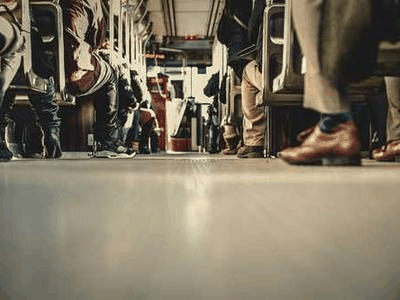

GIF saved as mygif.gif


In [45]:
if result and result["gif_data"]:
    # Display the GIF
    display(IPImage(data=result["gif_data"], format='gif'))
    
    # Ask if the user wants to save the GIF
    save_gif = input("Do you want to save the GIF? (yes/no): ").lower().strip()
    if save_gif == 'yes':
        filename = input("Enter the filename to save the GIF (e.g., output.gif): ").strip()
        if not filename.endswith('.gif'):
            filename += '.gif'
        with open(filename, 'wb') as f:
            f.write(result["gif_data"])
        print(f"GIF saved as {filename}")
    else:
        print("GIF not saved.")
else:
    print("No GIF data available to display or save.")

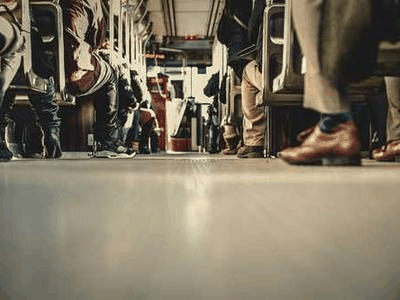

In [40]:
import io
import aiohttp
import asyncio
from PIL import Image
from IPython.display import display, Image as IPImage


async def get_image_data(session, url: str):
    """Fetch image data from a given URL."""
    async with session.get(url) as response:
        if response.status == 200:
            return await response.read()
    return None


async def create_gif():
    """Create a GIF from the generated images."""
    image_urls = [
        "https://fastly.picsum.photos/id/672/400/300.jpg?hmac=aW9DdMOISdmGtITiTV4aG3vW7OUHjyVmvecB8rjWhdA",
        "https://fastly.picsum.photos/id/790/400/301.jpg?hmac=VELjWS1r3PwluwR9Q2zuR_-YR8eNqTFEAW3oWcjQsBo",
        "https://fastly.picsum.photos/id/672/400/300.jpg?hmac=aW9DdMOISdmGtITiTV4aG3vW7OUHjyVmvecB8rjWhdA",
        "https://fastly.picsum.photos/id/672/400/300.jpg?hmac=aW9DdMOISdmGtITiTV4aG3vW7OUHjyVmvecB8rjWhdA",
        "https://fastly.picsum.photos/id/790/400/301.jpg?hmac=VELjWS1r3PwluwR9Q2zuR_-YR8eNqTFEAW3oWcjQsBo", ]
    images = []

    async with aiohttp.ClientSession() as session:
        tasks = [get_image_data(session, url) for url in image_urls if url]
        image_data_list = await asyncio.gather(*tasks)

    for img_data in image_data_list:
        if img_data:
            images.append(Image.open(io.BytesIO(img_data)))

    if images:
        gif_buffer = io.BytesIO()
        images[0].save(
            gif_buffer,
            format="GIF",
            save_all=True,
            append_images=images[1:],
            duration=2000,
            loop=0,
        )
        return gif_buffer.getvalue()
    return None


# Run the async function properly in Jupyter Notebook
async def run_async_task():
    gif_data = await create_gif()
    if gif_data:
        display(IPImage(data=gif_data, format="gif"))
    else:
        print("Failed to create GIF.")


# Use this instead of asyncio.run()
await run_async_task()

In [39]:


import cv2
from moviepy.editor import *
import os

def zoom_in(image, duration, fps, size):
    try:
        frames = []
        h, w = image.shape[:2]
        for i in range(int(duration * fps)):
            scale = 1 + (i / (duration * fps) * 0.5)
            center = (w // 2, h // 2)
            matrix = cv2.getRotationMatrix2D(center, 0, scale)
            frame = cv2.warpAffine(image, matrix, (w, h))
            frames.append(cv2.resize(frame, size))
        return frames
    except Exception as e:
        raise ValueError(f"Error in zoom_in function: {e}")

def zoom_out(image, duration, fps, size):
    try:
        frames = []
        h, w = image.shape[:2]
        for i in range(int(duration * fps)):
            scale = 1 + ((duration * fps - i) / (duration * fps) * 0.5)
            center = (w // 2, h // 2)
            matrix = cv2.getRotationMatrix2D(center, 0, scale)
            frame = cv2.warpAffine(image, matrix, (w, h))
            frames.append(cv2.resize(frame, size))
        return frames
    except Exception as e:
        raise ValueError(f"Error in zoom_out function: {e}")

def create_video(image_files, display_durations, size=(1080, 1920), fps=30):
    try:
        images = [cv2.resize(cv2.imread(img), size) for img in image_files]
        clips = []
        for i in range(len(images)):
            img = images[i]
            display_duration = display_durations[i]
            if i % 2 == 0:
                zoom_frames = zoom_in(img, display_duration, fps, size)
            else:
                zoom_frames = zoom_out(img, display_duration, fps, size)

            # Convert frames to video clips
            frames_clips = [ImageSequenceClip([cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)], fps=fps) for frame in zoom_frames]
            clip = concatenate_videoclips(frames_clips)
            clips.append(clip)

        # Combine all video clips into one video
        video_clip = concatenate_videoclips(clips, method="compose")
        return video_clip
    except Exception as e:
        raise ValueError(f"Error in create_video function: {e}")

def load_images_and_voices(images_root_folder, voices_root_folder):
    try:
        # Ensure paths are strings
        if not isinstance(images_root_folder, str) or not isinstance(voices_root_folder, str):
            raise ValueError("Image and voice folder paths should be strings.")
        
        images = sorted([os.path.join(images_root_folder, img) for img in os.listdir(images_root_folder)])
        voices = sorted([os.path.join(voices_root_folder, voice) for voice in os.listdir(voices_root_folder) if voice.endswith('.mp3')])
        return images, voices
    except Exception as e:
        raise ValueError(f"Error in load_images_and_voices function: {e}")

def combineAudioImages(images_subfolder, voices_subfolder, sceneList):
    try:
        # Ensure paths are strings
        if not isinstance(images_subfolder, str) or not isinstance(voices_subfolder, str):
            raise ValueError(f"Image and voice folder paths should be strings.{images_subfolder},{voices_subfolder}")

        images_root_folder = images_subfolder
        voices_root_folder = voices_subfolder
        
        images, voices = load_images_and_voices(images_root_folder, voices_root_folder)
        
        # Calculate display durations from audio files
        display_durations = []
        for file_path in voices:
            try:
                audio = AudioFileClip(file_path)
                duration_sec = audio.duration
                display_durations.append(duration_sec)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        
        video_clip = create_video(images, display_durations)
        
        # Combine audio files into one
        audio_clips = [AudioFileClip(path) for path in voices]
        combined_audio = concatenate_audioclips(audio_clips)
        
        if combined_audio.duration > video_clip.duration:
            combined_audio = combined_audio.subclip(0, video_clip.duration)

        # Set audio to video
        first_scene_title = sceneList[0]["title"].replace(" ", "_").replace(":", "").replace("/", "_")  
        video_filename = f"{first_scene_title}.mp4"
        final_clip = video_clip.set_audio(combined_audio)
        final_clip.write_videofile(video_filename)

        print(f"Combined video file created: {video_filename}")
        return f"video successfully created {video_filename}"
    except Exception as e:
        raise ValueError(f"Error in combineAudioImages function: {e}")
resp = combineAudioImages(combineAudioImages)    


Exception: Moviepy: ImageSequenceClip requires all images to be the same size

In [97]:
import pyttsx3

def speak(word):
    engine = pyttsx3.init()
    engine.setProperty("rate", 150)  # Adjust speed
    engine.setProperty("voice", "english")  # Select English voice
    engine.say(word)
    engine.runAndWait()

speak("drawn")  # Pronounce "August"


In [55]:
from gtts import gTTS
import os

def speak(word):
    tts = gTTS(text=word, lang="en", tld="us")  # "tld='us'" ensures an American accent
    tts.save("output.mp3")  # Save as audio file
    os.system("start output.mp3")  # Play the audio file (for Windows)

speak("This tutorial introduces a basic Question-Answering (QA) agent using LangChain and OpenAI's language model. The agent is designed to understand user queries and provide relevant, concise answers.")  # Pronounce "August"


In [60]:
!pip install scamp



     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
     ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
     -------------------- ------------------- 0.5/1.0 MB 932.9 kB/s eta 0:00:01
     ------------------------------- -------- 0.8/1.0 MB 860.9 kB/s eta 0:00:01
     ------------------------------- -------- 0.8/1.0 MB 860.9 kB/s eta 0:00:01
     ---------------------------------------- 1.0/1.0 MB 696.4 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'd

In [61]:
from scamp import Session

s = Session()
piano = s.new_part("piano")

# Play a simple melody
piano.play_note(60, 0.5, 1.0)  # Middle C
piano.play_note(62, 0.5, 1.0)  # D
piano.play_note(64, 0.5, 1.0)  # E
piano.play_note(67, 0.5, 1.0)  # G


Testing for working audio driver...
Found audio driver 'dsound'. This has been made the default, but it can be altered via the playback settings.
Using preset Piano Merlin for piano


In [62]:
!pip install pygame


In [3]:
from pydub.generators import Sine, WhiteNoise
from pydub import AudioSegment

# Generate a bass drum (low-frequency beat)
bass_drum = Sine(60).to_audio_segment(duration=200).fade_in(50).fade_out(50)

# Generate hi-hats (high-frequency beats)
hihat = WhiteNoise().to_audio_segment(duration=50).apply_gain(-10)

# Create a rhythm pattern
beat = (bass_drum + hihat * 2) * 42  # Repeat 4 times

# Save and play
beat.export("beat.wav", format="wav")
print("Beat generated and saved as 'beat.wav'.")


c:\Users\arman\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydub\utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
c:\Users\arman\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydub\utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
c:\Users\arman\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydub\utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
c:\Users\arman\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydub\utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


ModuleNotFoundError: No module named 'pyaudioop'

In [2]:
!pip install pydub

  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
which python  # or `where python` on Windows
python --version


ModuleNotFoundError: No module named 'pyaudioop'

In [66]:
!pip install mido


In [67]:
import mido
from mido import Message, MidiFile, MidiTrack

mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)

# Guitar chord (E minor)
notes = [40, 43, 47]  # MIDI notes for E minor

for note in notes:
    track.append(Message('note_on', note=note, velocity=64, time=0))
    track.append(Message('note_off', note=note, velocity=64, time=200))

# Save MIDI file
mid.save('guitar_chord.mid')
print("MIDI file 'guitar_chord.mid' created.")


MIDI file 'guitar_chord.mid' created.


In [91]:
import os
import shutil
import random
import tempfile
import pygame
import music21
from typing import Dict
from langgraph.graph import StateGraph, END 
from langchain.prompts import ChatPromptTemplate
from dotenv import load_dotenv
from typing_extensions import TypedDict

# Load environment variables and set OpenAI API key
load_dotenv()

# Initialize LLM
 

# Define the MusicState for the workflow
class MusicState(TypedDict):
    musician_input: str  # User input for music generation
    style: str           # Desired musical style
    melody: str          # Generated melody
    harmony: str         # Generated harmony
    rhythm: str          # Generated rhythm
    composition: str     # Complete music structure
    midi_file: str       # Path to the MIDI file

def melody_generator(state: MusicState) -> Dict:
    """Generate a melody based on user input."""
    prompt = ChatPromptTemplate.from_template(
        "Generate a melody based on this input: {input}. Represent it as a string of notes in music21 format."
    )
    chain = prompt | llm
    melody = chain.invoke({"input": state["musician_input"]})
    return {"melody": melody.content}

def harmony_creator(state: MusicState) -> Dict:
    """Generate harmony for the melody."""
    prompt = ChatPromptTemplate.from_template(
        "Create harmony for this melody: {melody}. Represent it as a string of chords in music21 format."
    )
    chain = prompt | llm
    harmony = chain.invoke({"melody": state["melody"]})
    return {"harmony": harmony.content}

def rhythm_analyzer(state: MusicState) -> Dict:
    """Generate rhythm pattern for the melody and harmony."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze and suggest a rhythm for this melody and harmony: {melody}, {harmony}. Represent it as a string of durations in music21 format."
    )
    chain = prompt | llm
    rhythm = chain.invoke({"melody": state["melody"], "harmony": state["harmony"]})
    return {"rhythm": rhythm.content}

def style_adapter(state: MusicState) -> Dict:
    """Adapt the composition to a specific style."""
    prompt = ChatPromptTemplate.from_template(
        "Adapt this composition to the {style} style: Melody: {melody}, Harmony: {harmony}, Rhythm: {rhythm}. Provide the result in music21 format."
    )
    chain = prompt | llm
    adapted = chain.invoke({
        "style": state["style"],
        "melody": state["melody"],
        "harmony": state["harmony"],
        "rhythm": state["rhythm"]
    })
    return {"composition": adapted.content}

def midi_converter(state: MusicState) -> Dict:
    """Convert the composition to a MIDI file and save it for download."""
    piece = music21.stream.Score()
    melody = music21.stream.Part()
    harmony = music21.stream.Part()

    # Create simple melody (C-E-G) and harmony (C major chord)
    note1 = music21.note.Note('C4')
    note1.quarterLength = 1
    melody.append(note1)

    chord1 = music21.chord.Chord(['C4', 'E4', 'G4'])
    chord1.quarterLength = 1
    harmony.append(chord1)

    piece.append(melody)
    piece.append(harmony)

    # Set tempo to 60 BPM
    piece.insert(0, music21.tempo.MetronomeMark(number=60))

    # Save as a temporary MIDI file
    temp_midi = tempfile.NamedTemporaryFile(delete=False, suffix='.mid')
    piece.write('midi', temp_midi.name)

    # Move the file to a permanent location
    download_path = os.path.join(os.getcwd(), "generated_music.mid")
    shutil.copy(temp_midi.name, download_path)

    return {"midi_file": download_path}

def play_midi(file_path):
    """Play the MIDI file using pygame."""
    pygame.init()
    pygame.mixer.init()
    pygame.mixer.music.load(file_path)
    pygame.mixer.music.play()
    
    print(f"Playing MIDI file: {file_path}")
    
    while pygame.mixer.music.get_busy():
        continue  # Keep playing until the music stops

# Initialize the StateGraph workflow
workflow = StateGraph(MusicState)

# Add nodes for each step
workflow.add_node("melody_generator", melody_generator)
workflow.add_node("harmony_creator", harmony_creator)
workflow.add_node("rhythm_analyzer", rhythm_analyzer)
workflow.add_node("style_adapter", style_adapter)
workflow.add_node("midi_converter", midi_converter)

# Define workflow execution order
workflow.set_entry_point("melody_generator")
workflow.add_edge("melody_generator", "harmony_creator")
workflow.add_edge("harmony_creator", "rhythm_analyzer")
workflow.add_edge("rhythm_analyzer", "style_adapter")
workflow.add_edge("style_adapter", "midi_converter")
workflow.add_edge("midi_converter", END)

# Compile the workflow
app = workflow.compile()

# Example user input
inputs = {
    "musician_input": "Create a happy piano piece in C major",
    "style": "Classical"
}

# Run the workflow
result = app.invoke(inputs)

print("Composition created 🎵")
print(f"MIDI file saved at: {result['midi_file']}")

# Play the generated MIDI file
play_midi(result["midi_file"])

Composition created 🎵
MIDI file saved at: e:\wmd\langgraph_and_crewai\langchain\generated_music.mid
Playing MIDI file: e:\wmd\langgraph_and_crewai\langchain\generated_music.mid


In [ ]:
!pip install music21

In [94]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END 
from langchain.prompts import ChatPromptTemplate
import music21
import pygame
import tempfile
import os
import random
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated 
from dotenv import load_dotenv

# Load environment variables and set OpenAI API key
load_dotenv()
class MusicState(TypedDict):
    """Define the structure of the state for the music generation workflow."""
    musician_input: str  # User's input describing the desired music
    melody: str          # Generated melody
    harmony: str         # Generated harmony
    rhythm: str          # Generated rhythm
    style: str           # Desired musical style
    composition: str     # Complete musical composition
    midi_file: str       # Path to the generated MIDI file
def melody_generator(state: MusicState) -> Dict:
    """Generate a melody based on the user's input."""
    prompt = ChatPromptTemplate.from_template(
        "Generate a melody based on this input: {input}. Represent it as a string of notes in music21 format."
    )
    chain = prompt | llm
    melody = chain.invoke({"input": state["musician_input"]})
    return {"melody": melody.content}

def harmony_creator(state: MusicState) -> Dict:
    """Create harmony for the generated melody."""
    prompt = ChatPromptTemplate.from_template(
        "Create harmony for this melody: {melody}. Represent it as a string of chords in music21 format."
    )
    chain = prompt | llm
    harmony = chain.invoke({"melody": state["melody"]})
    return {"harmony": harmony.content}

def rhythm_analyzer(state: MusicState) -> Dict:
    """Analyze and suggest a rhythm for the melody and harmony."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze and suggest a rhythm for this melody and harmony: {melody}, {harmony}. Represent it as a string of durations in music21 format."
    )
    chain = prompt | llm
    rhythm = chain.invoke({"melody": state["melody"], "harmony": state["harmony"]})
    return {"rhythm": rhythm.content}

def style_adapter(state: MusicState) -> Dict:
    """Adapt the composition to the specified musical style."""
    prompt = ChatPromptTemplate.from_template(
        "Adapt this composition to the {style} style: Melody: {melody}, Harmony: {harmony}, Rhythm: {rhythm}. Provide the result in music21 format."
    )
    chain = prompt | llm
    adapted = chain.invoke({
        "style": state["style"],
        "melody": state["melody"],
        "harmony": state["harmony"],
        "rhythm": state["rhythm"]
    })
    return {"composition": adapted.content}

def midi_converter(state: MusicState) -> Dict:
    """Convert the composition to MIDI format and save it as a file."""
    # Create a new stream
    piece = music21.stream.Score()

    # Add the composition description to the stream as a text expression
    description = music21.expressions.TextExpression(state["composition"])
    piece.append(description)

    # Define a wide variety of scales and chords
    scales = {
        'C major': ['C', 'D', 'E', 'F', 'G', 'A', 'B'],
        'C minor': ['C', 'D', 'Eb', 'F', 'G', 'Ab', 'Bb'],
        'C harmonic minor': ['C', 'D', 'Eb', 'F', 'G', 'Ab', 'B'],
        'C melodic minor': ['C', 'D', 'Eb', 'F', 'G', 'A', 'B'],
        'C dorian': ['C', 'D', 'Eb', 'F', 'G', 'A', 'Bb'],
        'C phrygian': ['C', 'Db', 'Eb', 'F', 'G', 'Ab', 'Bb'],
        'C lydian': ['C', 'D', 'E', 'F#', 'G', 'A', 'B'],
        'C mixolydian': ['C', 'D', 'E', 'F', 'G', 'A', 'Bb'],
        'C locrian': ['C', 'Db', 'Eb', 'F', 'Gb', 'Ab', 'Bb'],
        'C whole tone': ['C', 'D', 'E', 'F#', 'G#', 'A#'],
        'C diminished': ['C', 'D', 'Eb', 'F', 'Gb', 'Ab', 'A', 'B'],
    }

    chords = {
        'C major': ['C4', 'E4', 'G4'],
        'C minor': ['C4', 'Eb4', 'G4'],
        'C diminished': ['C4', 'Eb4', 'Gb4'],
        'C augmented': ['C4', 'E4', 'G#4'],
        'C dominant 7th': ['C4', 'E4', 'G4', 'Bb4'],
        'C major 7th': ['C4', 'E4', 'G4', 'B4'],
        'C minor 7th': ['C4', 'Eb4', 'G4', 'Bb4'],
        'C half-diminished 7th': ['C4', 'Eb4', 'Gb4', 'Bb4'],
        'C fully diminished 7th': ['C4', 'Eb4', 'Gb4', 'A4'],
    }

    def create_melody(scale_name, duration):
        """Create a melody based on a given scale."""
        melody = music21.stream.Part()
        scale = scales[scale_name]
        for _ in range(duration):
            note = music21.note.Note(random.choice(scale) + '4')
            note.quarterLength = 1
            melody.append(note)
        return melody

    def create_chord_progression(duration):
        """Create a chord progression."""
        harmony = music21.stream.Part()
        for _ in range(duration):
            chord_name = random.choice(list(chords.keys()))
            chord = music21.chord.Chord(chords[chord_name])
            chord.quarterLength = 1
            harmony.append(chord)
        return harmony

    # Parse the user input to determine scale and style
    user_input = state['musician_input'].lower()
    if 'minor' in user_input:
        scale_name = 'C minor'
    elif 'major' in user_input:
        scale_name = 'C major'
    else:
        scale_name = random.choice(list(scales.keys()))

    # Create a 7-second piece (7 beats at 60 BPM)
    melody = create_melody(scale_name, 7)
    harmony = create_chord_progression(7)

    # Add a final whole note to make it exactly 8 beats (7 seconds at 60 BPM)
    final_note = music21.note.Note(scales[scale_name][0] + '4')
    final_note.quarterLength = 1
    melody.append(final_note)
    
    final_chord = music21.chord.Chord(chords[scale_name.split()[0] + ' ' + scale_name.split()[1]])
    final_chord.quarterLength = 1
    harmony.append(final_chord)

    # Add the melody and harmony to the piece
    piece.append(melody)
    piece.append(harmony)

    # Set the tempo to 60 BPM
    piece.insert(0, music21.tempo.MetronomeMark(number=60))

    # Create a temporary MIDI file
    with tempfile.NamedTemporaryFile(delete=False, suffix='.mid') as temp_midi:
        piece.write('midi', temp_midi.name)
    
    return {"midi_file": temp_midi.name}        
# Initialize the StateGraph
workflow = StateGraph(MusicState)

# Add nodes to the graph
workflow.add_node("melody_generator", melody_generator)
workflow.add_node("harmony_creator", harmony_creator)
workflow.add_node("rhythm_analyzer", rhythm_analyzer)
workflow.add_node("style_adapter", style_adapter)
workflow.add_node("midi_converter", midi_converter)

# Set the entry point of the graph
workflow.set_entry_point("melody_generator")

# Add edges to connect the nodes
workflow.add_edge("melody_generator", "harmony_creator")
workflow.add_edge("harmony_creator", "rhythm_analyzer")
workflow.add_edge("rhythm_analyzer", "style_adapter")
workflow.add_edge("style_adapter", "midi_converter")
workflow.add_edge("midi_converter", END)

# Compile the graph
app = workflow.compile()
inputs = {
    "musician_input": "Create a happy piano piece in C major",
    "style": "Romantic era"
}

# Invoke the workflow
result = app.invoke(inputs)

print("Composition created")
print(f"MIDI file saved at: {result['midi_file']}")

Composition created
MIDI file saved at: C:\Users\arman\AppData\Local\Temp\tmpfb_vjtvx.mid
